# Introducción y Contexto

# 02_Modelo_sQ – Sistema de Revisión Continua
Este notebook implementa el modelo prescriptivo (s, Q) para el caso Retail, usando los datos preparados en el `01_eda.ipynb`.

## Objetivos:
- Calcular el lote económico de pedido (Q*) y el punto de reorden (s).
- Evaluar políticas logísticas bajo distintos escenarios.
- Estimar costos totales (pedido, mantenimiento, rotura y almacenamiento).
- Preparar la base para el Dashboard Prescriptivo.


# Cargar datos preparados

In [1]:
import pandas as pd
import numpy as np

# Cargar métricas del EDA
metricas_venta = pd.read_csv("metricas_venta_integradas.csv")

# Cargar escenarios logísticos
costos = pd.read_csv("../data/Costos_Logisticos.csv")
costos.columns = costos.columns.str.strip().str.lower()

print("✅ Datos cargados correctamente")
print("Métricas:", metricas_venta.shape)
print("Escenarios:", costos.shape)

✅ Datos cargados correctamente
Métricas: (1000, 15)
Escenarios: (5, 7)


# Modelo (s, Q) Base

Q* → lote óptimo de pedido

s → punto de reorden

CTA → costo total anual estimado

In [2]:
import numpy as np
import pandas as pd

# -----------------------------
# 1️⃣ Bucle principal: cálculo (s, Q) + CTE
# -----------------------------
resultados = []

for _, row in costos.iterrows():
    escenario = row['escenario']
    S = row['costo_pedido']
    h = row['costo_mantenimiento_anual']
    Z = 1.65  # Nivel de servicio 95 %

    print(f"🧩 Procesando {escenario} | S={S} | h={h}")

    df = metricas_venta.copy()
    df['D'] = df['demanda_promedio'] * 52
    df['H'] = h * df['costo_unitario']

    # Modelo (s, Q)
    df['Q_opt'] = np.sqrt((2 * df['D'] * S) / df['H'])
    df['D_L'] = df['demanda_promedio'] * df['lead_time']
    df['sigma_L'] = df['desviacion_demanda'] * np.sqrt(df['lead_time'])
    df['s_reorder'] = df['D_L'] + Z * df['sigma_L']

    # Costo total anual básico
    df['CTA'] = (df['D'] / df['Q_opt']) * S + (df['Q_opt'] / 2) * df['H']

    # Costo total extendido (con tu diccionario)
    df['CTE'] = (
        df['CTA']
        + row['costo_almacenamiento_m2'] * 12 * df['D'] / 52 * 0.05
        + row['costo_transferencia_tienda'] * 0.02 * df['D']
        + row['costo_rotura_stock'] * df['margen_promedio'] * 0.05
        + row['costo_obsolescencia'] * df['margen_promedio'] * 0.03
    )

    df['escenario'] = escenario
    resultados.append(df)

# -----------------------------
# 2️⃣ Unir todos los escenarios
# -----------------------------
df_sQ = pd.concat(resultados, ignore_index=True)
print("✅ Cálculo (s, Q) y CTE completado correctamente.")

🧩 Procesando Escenario 1 | S=10.0 | h=0.15
🧩 Procesando Escenario 2 | S=40.0 | h=0.2
🧩 Procesando Escenario 3 | S=50.0 | h=0.25
🧩 Procesando Escenario 4 | S=55.0 | h=0.3
🧩 Procesando Escenario 5 | S=60.0 | h=0.35
✅ Cálculo (s, Q) y CTE completado correctamente.


In [3]:
# -----------------------------
# 3️⃣ Resumen comparativo
# -----------------------------
resumen_cte = (
    df_sQ.groupby('escenario')
    .agg(
        Q_promedio=('Q_opt', 'mean'),
        s_promedio=('s_reorder', 'mean'),
        CTA_total=('CTA', 'sum'),
        CTE_total=('CTE', 'sum')
    )
    .reset_index()
)

print("📊 Resumen comparativo:")
print(resumen_cte)

📊 Resumen comparativo:
     escenario  Q_promedio  s_promedio      CTA_total      CTE_total
0  Escenario 1   21.608094   15.525764   82508.862679  164070.164024
1  Escenario 2   37.426317   15.525764  190546.056314  292917.014881
2  Escenario 3   37.426317   15.525764  238182.570392  361363.186182
3  Escenario 4   35.832970   15.525764  273650.939386  408110.155434
4  Escenario 5   34.650037   15.525764  308719.895518  454421.199634


# Visualización comparativa de escenarios

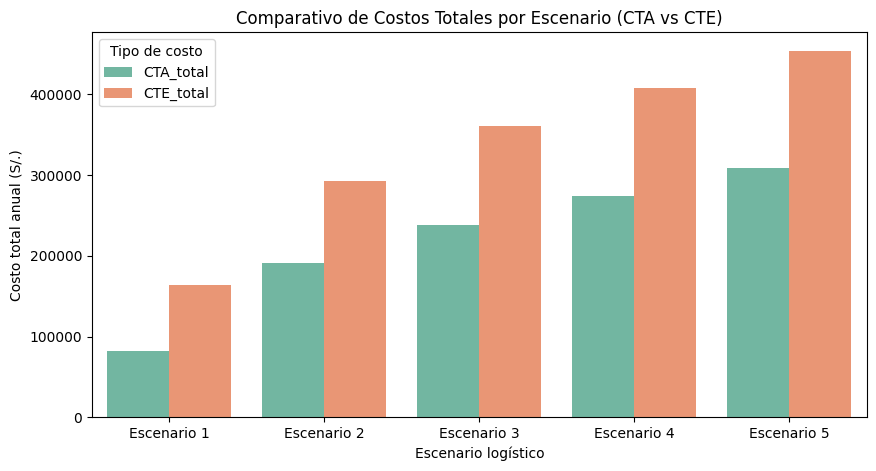

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.barplot(
    data=resumen_cte.melt(
        id_vars='escenario',
        value_vars=['CTA_total','CTE_total'],
        var_name='TipoCosto', value_name='CostoTotal'
    ),
    x='escenario', y='CostoTotal', hue='TipoCosto', palette='Set2'
)
plt.title("Comparativo de Costos Totales por Escenario (CTA vs CTE)")
plt.xlabel("Escenario logístico")
plt.ylabel("Costo total anual (S/.)")
plt.legend(title='Tipo de costo')
plt.show()

In [5]:
df_sQ.to_csv("resultados_modelo_sQ.csv", index=False)
resumen_cte.to_csv("resumen_escenarios.csv", index=False)
